In [1]:
import torchvision.models as models
import torch.nn as nn,pandas as pd,torch,os,cv2 as cv,numpy as np
from torchvision import transforms


from time import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from regDataset import binary_acc,RegDataset
from regModels import RegModelOnlyDiff

In [2]:
# pred - shape - shape+confidence(0 or 1)
# TP,FP, TN,FN - Input Img,PredMask, Rec, Gt Mask
# Doc - Predictions details,Future scope

In [3]:
# df = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/reg.csv")
# c=0
# for fl in df.RecInput:
#     if not os.path.exists(fl): c+=1
# print(c)
# df = df[df.RecInput.apply(lambda x: os.path.exists(x))]
# for data in ['Train','Val','Test']:
#     df[df.Data==data].to_csv(f"/home/pictor/workspace/Akhil/Confidence/Data/RegData/{data}Reg.csv")

In [4]:
dfTrain = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TrainReg.csv")
dfTrain.head()

Unnamed: 0       IoU  accuracy  \
0           0  0.525488  0.937097   
1           1  0.668481  0.952417   
2           2  0.298922  0.909215   
3           3  0.901852  0.976186   
4           4  0.869438  0.968593   

                                            predMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                              gtMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            RecInput  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            InputImg  Epoch   Data  
0  /home/pictor/workspace/Akhil/Confidence/Data/R...    126  Train  
1  /home/pictor/workspace/Akhil/Confidence/Data/R...     66  Train  
2  /home/pictor/workspace/Akhil/Confidence/Data/R...    156  Train  
3  /home/pictor/workspace/Akhil/Confidence/Data/R...    126  Train  
4  /home/pictor/workspace/Akhil/Confidence/Data/R...    161  Train

In [5]:
dfVal = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/ValReg.csv")
dfTest = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TestReg.csv")
dfTrain.shape,dfVal.shape,dfTest.shape

((13971, 9), (3570, 9), (2835, 9))

In [6]:
threshold = 0.8
metricCol = 'IoU'
label_function = lambda x: 0 if x<threshold else 1
dfTrain.loc[:,'label'] = dfTrain[metricCol].apply(label_function)
dfVal.loc[:,'label'] = dfVal[metricCol].apply(label_function)
dfTest.loc[:,'label'] = dfTest[metricCol].apply(label_function)


In [7]:
dfTrain.label.value_counts(1)

0    0.531386
1    0.468614
Name: label, dtype: float64

In [8]:
dfVal.label.value_counts(1)

0    0.586275
1    0.413725
Name: label, dtype: float64

In [9]:
dfTest.label.value_counts(1)

0    0.522751
1    0.477249
Name: label, dtype: float64

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
im_size = 512
preprocess_rgb = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,), std=(0.229,)),
])

In [12]:
batch_size = 64
train_dataset = RegDataset(dfTrain,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)
val_dataset = RegDataset(dfVal,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

test_dataset = RegDataset(dfTest,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)


In [13]:
n_epochs = 100
val_freq = 3
# model = RegModel()
# model.to(device)

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
model = RegModelOnlyDiff()
model.to(device)
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008,weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95,verbose=True)

Adjusting learning rate of group 0 to 8.0000e-03.


In [15]:
model_save_path = '/home/pictor/workspace/Akhil/Confidence/codes/regModels/RegModelOnlyDiff.pt'

In [ ]:
mxAcc = max(accuracy_stats['val']) if accuracy_stats['val'] else 0
for epoch in range(1,n_epochs+1):
    model.train()
    t = time()
    # if epoch!=1:
    train_epoch_loss = train_epoch_acc = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        y_pred_train = model(batch).squeeze()
        loss = lossFn(y_pred_train,batch['Y'].to(device))
        acc = binary_acc(y_pred_train,batch['Y'].to(device))
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss
        train_epoch_acc += acc
    if epoch%val_freq==0 or epoch==1:
        with torch.no_grad():
            model.eval()
            val_epoch_loss = val_epoch_acc = 0
            for val_batch in tqdm(val_dataloader):
                y_pred_val = model(val_batch).squeeze()
                val_loss = lossFn(y_pred_val,val_batch['Y'].to(device))
                val_acc = binary_acc(y_pred_val,val_batch['Y'].to(device))
                val_epoch_loss += val_loss
                val_epoch_acc += val_acc

            loss_stats['val'].append(val_epoch_loss/len(val_dataloader))
            accuracy_stats['val'].append(val_epoch_acc/len(val_dataloader))

            if val_acc > mxAcc:
                torch.save(model,model_save_path)
                mxAcc = val_acc

    time_taken = time()-t
    loss_stats['train'].append(train_epoch_loss/len(train_dataloader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataloader))

    if epoch%val_freq==0 or epoch==1:
        print(f'Epoch {epoch+0:02}, Time {time_taken:.2f}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Val Loss: {val_epoch_loss/len(val_dataloader):.5f} |\
         Train Acc: {train_epoch_acc/len(train_dataloader):.3f}| Val Acc: {val_epoch_acc/len(val_dataloader):.3f}')
    else:
        print(f'Epoch {epoch+0:02}, Time {time_taken:.2f}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Train Acc: {train_epoch_acc/len(train_dataloader):.3f}|')

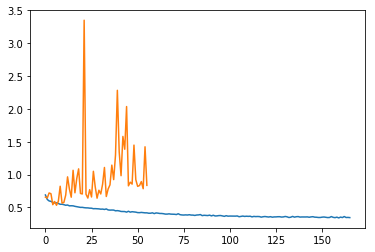

In [17]:
plt.plot(loss_stats['train']);
plt.plot(loss_stats['val']);

In [18]:
plt.plot(accuracy_stats['train']);
plt.plot(accuracy_stats['val']);